---
# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
""" Imports """
import cv2
import numpy as np
import matplotlib.pyplot as plt
# uncomment next line when running code in jupyter notebook
%matplotlib inline
import glob
import matplotlib.cm as cm



In [2]:
class Points:
    """ Static class """
    objpoints = []
    imgpoints = []



In [3]:
def find_corner_coordinates_and_map_to_reference_chessboard():
    """
    Create 9 col x 6 row grid reference coordinates aka 3D objpoints.
    Locate corners surrounded by 4 squares in calibration images and store coordinates aka 2D imgpoints
    """
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    images = glob.glob('camera_cal/calibration*.jpg')
    for img in images:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret:
            Points.imgpoints.append(corners)
            Points.objpoints.append(objp)
    print("Grid setup done.")



In [4]:
def calculate_camera_distortion_coefficients(img, objpts, imgpts):
    """
    aka calibrate camera
    :param img: to calculate against
    :param objpts: 3D grid coordinates from Points class
    :param imgpts: 2D image corner coordinates from Points class
    :return: camera_matrix, distortion_coefficients
    """
    img_size = (img.shape[1], img.shape[0])
    return_value, camera_matrix, distortion_coefficients, rotation_vectors, \
        translation_vectors = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
    print("Distortion coefficients calculated.")
    return camera_matrix, distortion_coefficients



In [5]:
def undistort_image(img, mtx, dist):
    """
    Undistort the image.
    :param img: image
    :param mtx: camera attributes matrix
    :param dist: distortion coefficients
    :return: undistorted image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    print("Image undistorted.")
    return undist



In [6]:
def compare_raw_distorted_against_undistorted_images(raw_1, undist_1, raw_2, undist_2):
    """
    Side-by-side visual comparison test.
    :param raw_1: distorted image
    :param raw_2: 2nd distorted image
    :param undist_1: undistorted image
    :param undist_2: 2nd undistorted image
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(15)

    fig.add_subplot(2, 2, 1)
    plt.title("Distorted Images")
    plt.imshow(raw_1, cmap='gray')
    fig.add_subplot(2, 2, 2)
    plt.title("Undistorted Images")
    plt.imshow(undist_1, cmap='gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(raw_2)
    fig.add_subplot(2, 2, 4)
    plt.imshow(undist_2)

    # IMPORTANT : uncomment when running from Jupyter Notebook
    plt.show()

    print("Side-by-side views done.")



### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [7]:
find_corner_coordinates_and_map_to_reference_chessboard()

calibration_img = cv2.imread("camera_cal/calibration1.jpg")
c_matrix, dist_coeff = calculate_camera_distortion_coefficients(calibration_img, Points.objpoints,
                                                                Points.imgpoints)


Grid setup done.
Distortion coefficients calculated.


### 2. Apply a distortion correction to raw images.

Image undistorted.
Image undistorted.


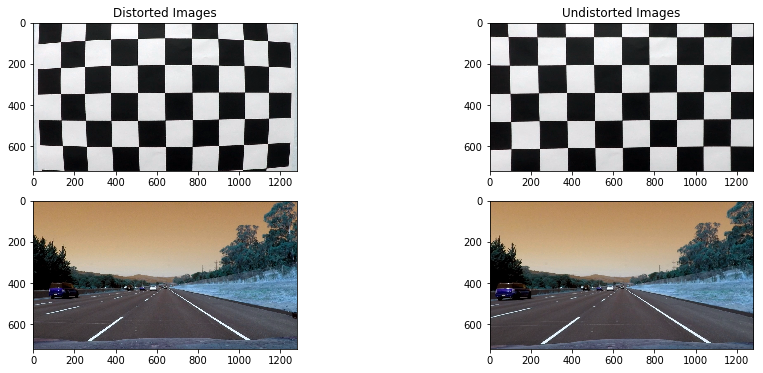

Side-by-side views done.


In [8]:
# calibration images
undistorted_calibration_img = undistort_image(calibration_img, c_matrix, dist_coeff)
cv2.imwrite('camera_cal/undist_calibration1.jpg', undistorted_calibration_img)

# straight lane line images
straight_lines_image_2 = cv2.imread('test_images/straight_lines2.jpg')
undistorted_straight_lines_2 = undistort_image(straight_lines_image_2, c_matrix, dist_coeff)
cv2.imwrite('output_images/undistorted_straight_lines2.jpg', undistorted_straight_lines_2)

# View results
compare_raw_distorted_against_undistorted_images(calibration_img, undistorted_calibration_img, 
                                                 straight_lines_image_2,
                                                 undistorted_straight_lines_2)


### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [9]:
def sobel_gradient_direction(copy_of_colour_image, sobel_kernel=3):
    """
     Define a function that applies Sobel x and y, then computes the direction (radians) of the gradient.
    :param copy_of_colour_image: to process
    :param sobel_kernel: window size for calculating x and y gradients
    :return:
    """
    gray = cv2.cvtColor(copy_of_colour_image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))  # radians aka approx. angles
    return abs_grad_dir



In [10]:
def extract_saturation_channel(colour_img):
    """
    Convert colour image into HLS channels and extract saturation channel.
    :param colour_img: image to extract s channel ndarray from
    :return: image saturation channel ndarray
    """
    hls = cv2.cvtColor(colour_img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:, :, 2]  # aka 3rd channel
    return s_channel



In [11]:
def view_transformed_images(gradient_saturation_binary_image, combined_saturation_gradient_colour_binary_image):
    """
    View the images output from the transformation pipeline.
    :param gradient_saturation_binary_image: Directional, S channel, binary thresholded image.
    :param combined_saturation_gradient_colour_binary_image: S channel, Directional, Yellows, binary 
        thresholded image. 
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(15)

    fig.add_subplot(2, 2, 1)
    plt.title("Gradient Saturation Binary")
    plt.imshow(gradient_saturation_binary_image)
    fig.add_subplot(2, 2, 2)
    plt.title("Gradient Saturation Colour Binary")
    plt.imshow(combined_saturation_gradient_colour_binary_image, cmap='gray')

    # IMPORTANT : uncomment when running from Jupyter Notebook
    plt.show()

    print("Binary side-by-side views done.")



In [12]:
def colour_image_transformation_pipeline(colour_image, s_thresh=(180, 255), sobel_threshold_range=(40, 100),
                                         rgb_thresh=(200, 255)):
    """
    Image information extraction pipeline.
    :param colour_image: input image
    :param s_thresh: saturation threshold range
    :param sobel_threshold_range: gradient direction threshold range
    :param rgb_thresh: colour intensity threshold range
    :return: grad_sat_bin_image, stacked_s_g_c_bin_image
    """
    copy_of_colour_image = np.copy(colour_image)

    # Extract S channel
    saturation_channel = extract_saturation_channel(copy_of_colour_image)

    # Calculate line directions
    sobel_gradient_directions = sobel_gradient_direction(copy_of_colour_image)

    # Threshold gradient
    sobel_binary = np.zeros_like(sobel_gradient_directions)
    sobel_binary[(sobel_gradient_directions >= sobel_threshold_range[0]) & (
    sobel_gradient_directions <= sobel_threshold_range[1])] = 1

    # Threshold RGB channel for range (200, 255) aka yellows
    yellow = copy_of_colour_image[:, :, 0]
    yellow_binary = np.zeros_like(yellow)
    yellow_binary[(yellow > rgb_thresh[0]) & (yellow <= rgb_thresh[1])] = 1

    # Threshold colour intensity
    saturation_binary = np.zeros_like(saturation_channel)
    saturation_binary[(saturation_channel >= s_thresh[0]) & (saturation_channel <= s_thresh[1])] = 1

    # Stack dimensions
    grad_sat_bin_image = np.dstack((np.zeros_like(sobel_binary), sobel_binary, saturation_binary))
    stacked_s_g_c_bin_image = np.zeros_like(sobel_binary)
    stacked_s_g_c_bin_image[(saturation_binary == 1) | (sobel_binary == 1) | (yellow_binary == 1)] = 1
    print("colour_image_transformation_pipeline processing done")
    return grad_sat_bin_image, stacked_s_g_c_bin_image



colour_image_transformation_pipeline processing done


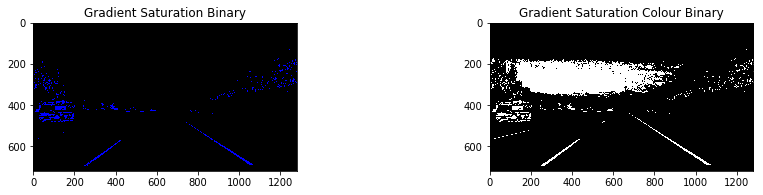

Binary side-by-side views done.


In [13]:
# Extract information from image
grad_sat_bin_image, stacked_sat_grad_colour_bin_image = colour_image_transformation_pipeline(
    undistorted_straight_lines_2)

# Save outputs
plt.imsave('output_images/colour_binary_straight_lines2.png', np.array(grad_sat_bin_image))
plt.imsave('output_images/stacked_binary_straight_lines2.png', np.array(stacked_sat_grad_colour_bin_image),
           cmap=cm.gray)

# View outputs
view_transformed_images(grad_sat_bin_image, stacked_sat_grad_colour_bin_image)


### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [14]:
def view_polygon_and_warped_images(polygon_overlay_image, warped_polygon_overlay_image):
    """
    View the undistored image with polygon lane line and warped image from overhead viewpoint with
        destination points drawn.
    :param polygon_overlay_image: image with overlay
    :param warped_polygon_overlay_image: overhead view of image with overlay
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(15)

    fig.add_subplot(2, 2, 1)
    plt.title("Undistorted image with polygon overlay")
    plt.imshow(polygon_overlay_image)
    fig.add_subplot(2, 2, 2)
    plt.title("Warped image from overhead viewpoint")
    plt.imshow(warped_polygon_overlay_image)

    # IMPORTANT : uncomment when running from Jupyter Notebook
    plt.show()

    print("Polygon and warped side-by-side views done.")



In [15]:
def define_source_polygon():
    """
    Define 4 corners of polygon region of undistorted image. 
    """
    global source_transformation
    source_transformation = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])



In [16]:
def define_destination_polygon():
    """
    Define 4 corners of polygon region to warp transform onto.
    """
    global destination_transformation
    destination_transformation = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])



In [17]:
def warp_perspective_to_top_down(src, img, dst):
    """
    Calculate the inversed transformation matrix and
    :param src: source points where warp transforms from
    :param img: stacked binary thresholded image that includes saturation, gradient direction, colour intensity
    :param dst: destination points where warp transforms to
    :return: the transformation matrix inversed, warped top-down binary image
    """
    transformation_matrix = cv2.getPerspectiveTransform(src, dst)  # the transform matrix
    transformation_matrix_inverse = cv2.getPerspectiveTransform(dst, src)  # the transform matrix inverse
    warped_to_top_down = cv2.warpPerspective(img, transformation_matrix, img_size)  # warp image to a top-down view
    return transformation_matrix_inverse, warped_to_top_down



In [18]:
def polygon():
    """
    Create green polygon and overlay on undistorted image.
    """
    global polygon_undistored_image
    polygon_undistored_image = cv2.line(undistorted_straight_lines_2, (240, 700), (610, 440), [0, 255, 0], 4)
    polygon_undistored_image = cv2.line(undistorted_straight_lines_2, (240, 700), (1080, 700), [0, 255, 0], 4)
    polygon_undistored_image = cv2.line(undistorted_straight_lines_2, (1080, 700), (670, 440), [0, 255, 0], 4)
    polygon_undistored_image = cv2.line(undistorted_straight_lines_2, (610, 440), (670, 440), [0, 255, 0], 4)



### 5. Detect lane pixels and fit to find the lane boundary.

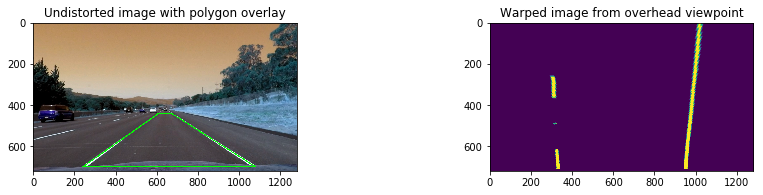

Polygon and warped side-by-side views done.


In [19]:
# Get image 2D size
img_size = (undistorted_straight_lines_2.shape[1], undistorted_straight_lines_2.shape[0])

# Set 4 corners of warp source polygon
define_source_polygon()

# Set 4 corners of warp destination polygon
define_destination_polygon()

# Create polygon overlayed onto undistorted image
polygon()

# Engage warp drive :)
matrix_transform_inversed, top_down_warped_binary = warp_perspective_to_top_down(source_transformation,
                                                                                 stacked_sat_grad_colour_bin_image,
                                                                                 destination_transformation)




# Store output
cv2.imwrite('output_images/lined_image_straight_lines2.jpg', polygon_undistored_image)
cv2.imwrite('output_images/warped_straight_lines2.jpg', top_down_warped_binary)

# View output
view_polygon_and_warped_images(polygon_undistored_image, top_down_warped_binary)


top_down_warped_binary.shape :  (720, 1280)


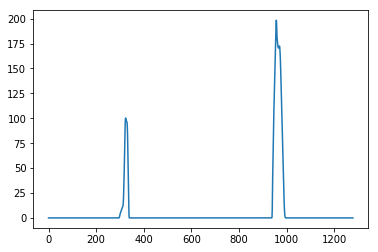

In [20]:
histogram = np.sum(top_down_warped_binary[top_down_warped_binary.shape[0]//2:,:], axis=0)
print("top_down_warped_binary.shape : ", top_down_warped_binary.shape)
plt.plot(histogram)

### 6.1 Determine the curvature of the lane

In [ ]:
class Line:
    # Define a class to receive the characteristics of each line detection
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_x_fitted = []
        # average x values of the fitted line over the last n iterations
        self.best_x = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.all_x = None
        # y values for detected line pixels
        self.all_y = None



In [ ]:
def get_offset_from_center(right_x_base, left_x_base, midpoint):
    return (3.7 / 700) * abs(((right_x_base - left_x_base) / 2) + left_x_base - midpoint)



In [ ]:
def initiate_lines(binary_warped, left_line, right_line):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines

    # left_line = Line()
    # right_line = Line()
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    offset_from_center = get_offset_from_center(rightx_base, leftx_base, midpoint)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_line.allx = leftx
    left_line.ally = lefty
    right_line.allx = rightx
    right_line.ally = righty

    # print(len(leftx), '  ', len(lefty))
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    left_line.recent_x_fitted.append(left_fitx)
    right_line.recent_x_fitted.append(right_fitx)
    left_line.bestx = left_fitx
    right_line.bestx = right_fitx
    return offset_from_center, left_line, right_line, ploty



In [ ]:
def find_line(binary_warped, left_line, right_line, n):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    if len(left_line.recent_x_fitted) or len(right_line.recent_x_fitted) == 0:
        offset_from_center, left_line, right_line, ploty = initiate_lines(binary_warped, left_line,
                                                                          right_line)
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 20
    left_lane_inds = (
        (nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
            nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
            nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # print (right_fitx[0]-left_fitx[0])
    # check to see if the two lines found have the proper distance and are roughly parallel
    # print (have_proper_distance(left_fitx, right_fitx))
    if (are_roughly_parallel(left_fitx, right_fitx) and have_proper_distance(left_fitx, right_fitx)):
        left_line.recent_x_fitted.append(left_fitx)
        right_line.recent_x_fitted.append(right_fitx)
        if len(left_line.recent_x_fitted) > n:
            np.delete(left_line.recent_x_fitted, 0)
            np.delete(right_line.recent_x_fitted, 0)
        left_line.bestx = np.average(left_line.recent_x_fitted, axis=0)
        right_line.bestx = np.average(right_line.recent_x_fitted, axis=0)
        # left_line.recent_x_fitted.append(left_fitx)
        # right_line.recent_x_fitted.append(right_fitx)
        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
    else:
        left_line.invalid_count = + 1
        # right_line.invalid_count =+ 1
        # left_line.recent_x_fitted.append(left_line.best_x)
        # right_line.recent_x_fitted.append(right_line.best_x)
        if (left_line.invalid_count > 60):
            offset_from_center, left_line, right_line, ploty = initiate_lines(binary_warped, left_line,
                                                                              right_line)
            left_line.invalid_count = 0
    offset_from_center = get_offset_from_center(right_fitx[0], left_fitx[0], binary_warped.shape[1] / 2)
    # if (offset_from_center > 0.95):
    #    offset_from_center, left_line, right_line, ploty = initiate_lines(binary_warped)
    return offset_from_center, left_line, right_line, ploty



In [ ]:
def draw_polynomial(points):
    previous = points[0]
    for point in points:
        cv2.line(out_img, (int(previous[0]), int(previous[1])), (int(point[0]), int(point[1])), [255, 255, 0],
                 10)
        previous = point



In [ ]:
# Generate x and y values for plotting
left_line = Line()
right_line = Line()
img = cv2.imread('test_images/test5.jpg')
undistorted = undistort_image(img, c_matrix, dist_coeff)
thresholded = colour_image_transformation_pipeline(undistorted)
minv1, binary_warped1 = warp_perspective_to_top_down(source_transformation, thresholded[1],
                                                     destination_transformation)
offset_from_center, left_line, right_line, ploty = initiate_lines(binary_warped1, left_line, right_line)
ploty = np.linspace(0, binary_warped1.shape[0] - 1, binary_warped1.shape[0])
left_fitx = left_line.current_fit[0] * ploty ** 2 + left_line.current_fit[1] * ploty + \
            left_line.current_fit[2]
right_fitx = right_line.current_fit[0] * ploty ** 2 + right_line.current_fit[1] * ploty + \
             right_line.current_fit[2]
out_img = np.dstack((binary_warped1, binary_warped1, binary_warped1)) * 255
out_img[left_line.ally, left_line.allx] = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]

left_points = np.array(np.column_stack((left_line.recent_x_fitted[0], ploty)))

right_points = np.array(np.column_stack((right_line.recent_x_fitted[0], ploty)))

draw_polynomial(left_points)
draw_polynomial(right_points)
plt.imsave('output_images/polynomial_fitted.jpg', out_img)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img)


# TODO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

""" Structure """
import calibrated_camera as camera
import gradient_image
import hls_image
import lane_lines

In [ ]:
display = True

# TODO 2. Iterate over each frame in the video, applying all steps below until detect lane lines
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    test_img = cv2.imread(fname)
    if display:
        cv2.imshow('test_img', test_img)
        cv2.waitKey(1000)
        cv2.destroyAllWindows()
    # video_frame = ""
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    """ Computer Vision Setup """
    # 1. Calibrate Camera and Correct Distortion

    # points = camera.Points()
    # points.map_3d_object_to_2d_image_points(store=False, display=False)  # To test, set params (store=False, display=True)
    # print("points.imgpoints : ", points.imgpoints)  # 9x6 = 54 x,y coordinate lists per image array.
    undistorted_img = camera.calibrate_and_undistort(test_img, show_undistored_img=False)

    # Step through the list and apply colour and gradient thresholds

    # TODO 3. Colour and Gradient Thresholds
    # ------------------
    # 3.1 Apply colour threshold
    # filter_thresh = (0, 255)  # Colour intensity filter aka NO FILTER. Result == all black image returned. List of 1's
    filter_thresh = (90, 255)  # Colour intensity filter. Result == all black image returned. List start all 1's, ends all 0's
    # filter_thresh = (100, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (110, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (120, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (125, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (128, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (129, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (130, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (140, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (160, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (168, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (170, 255)  # Colour intensity filter. Result == all black image returned. List starts all 0's, ends all 0's

    # test_img = hls_image.IntenseColoursMask.TEST_IMAGE  # Test image.
    hls_image.IntenseColoursMask.view_hls_binary_mask(undistorted_img, filter_thresh)  # TODO toggle comment
    # print(video_frame)
    # intense_colours_mask = hls_image.IntenseColoursMask.hls_select(undistorted_img, filter_thresh)  # TODO uncomment

    # Visual test
    # hls_image.IntenseColoursMask.view_hls_test()
    # hls_image.IntenseColoursMask.view_hls_binary_mask(undistorted_img, filter_thresh)  # TODO toggle comment
    # ------------------
    # 3.2. Generate gradient direction binary mask
    sobel_kernel_size = 15
    # threshold = (0.7, 1.3)  # note : default absolute radians filter is pi/2 (aka 90-degrees)
    threshold = (0, np.pi / 2)  # default

    # test_img = gradient_image.GradientBinaryMask.TEST_IMAGE  # Test image
    # direction_binary_mask = gradient_image.GradientBinaryMask.dir_threshold(undistorted_img, sobel_kernel_size, threshold)  # TODO uncomment

    # Visual test
    # gradient_image.GradientBinaryMask.view_mask_test(undistorted_img, sobel_kernel_size, threshold)  # TODO toggle comment
    # ------------------

    # TODO 4. Transform Perspective


    """ Find Real Lane Lines : Base Measurement """
    # TODO 5. Detect Lane Lines


    # TODO 6. Determine Lane Curvature
    # TODO TEST : Automatically determining if your detected lines are the real thing :
    # TODO 6.1. Check curvature : that both left and right lines have similar curvature.
    # TODO 6.2. Check separation : that they are separated by approx the correct distance horizontally
    # TODO 6.3. Check parallel : that they are roughly parallel.
    # TODO 6.4. Finding your offset from lane centre : assume camera is mounted at centre of car, so lane centre is at midpoint at bottom of image.


    # TODO Keeping track of recent measurements : instantiate lane_lines.Line for both left and right lane lines to keep track of recent values from previously processed images.


    """ Find Real Lane Lines : Next Measurement """
    # TODO 7. search within a window around the previous detection, then perform TEST
    """
    After determining you found the lines, where to look in the next frame :
    simply search within a window around the previous detection

    For example, if you fit a polynomial (WARN : I'd like to apply finding_the_lines_convolution.py instead!!!), then
    for each y position, you have an x position that represents the lane center from the last frame.
    Search for the new line within +/- some margin around the old line center.
    See finding_the_lines.py, Step 5 for details.

    Then do automatic test if detected lines are real aka check curvature, separation, parallel.
    """

    """
    If you lose track of the lines : assume just a bad image for 3-5 consecutive frames and use previous positions from
    last good frame.

    Else, go back to the blind search method using a histogram and sliding window, or other method,
    to re-establish your measurement.

    """

    """
    Smoothing (average) your measurements over last n frames.

    """

    """
    Drawing the line back down onto the road

    Once you have a good measurement of the line positions in warped space,
    it's time to project your measurement back down onto the road!

    Let's suppose, as in the previous example, you have a warped binary image called warped, and
    you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which
    represent the x and y pixel values of the lines.
    You can then project those lines onto the original image as follows:
    """
    # # Create an image to draw the lines on
    # warp_zero = np.zeros_like(warped).astype(np.uint8)
    # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #
    # # Recast the x and y points into usable format for cv2.fillPoly()
    # pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    # pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    # pts = np.hstack((pts_left, pts_right))
    #
    # # Draw the lane onto the warped blank image
    # cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #
    # # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # # Combine the result with the original image
    # result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # plt.imshow(result)

